# Дипломная работа по курсу "Аналитик данных"
        

    
## Оглавление
### [Описание данных](#description)  
### [Общая информация о данных](#task1)  
### [Подготовка датасета к анализу](#task2) 
### [EDA](#task3)  
#### [Gender](#task3.1)  
#### [Married](#task3.2)  
#### [Dependents](#task3.3)  
#### [Education](#task3.4)
#### [Self-Employed](#task3.5)
#### [Income](#task3.6)  
#### [LoanAmount](#task3.7)    
#### [Loan_Amount_Term](#task3.8)  
#### [Credit_History](#task3.9)  
#### [Property_Area](#task3.10)
#### [Tests](#task3.11)
### [Preprocessing](#task4)  
### [Model](#task5)  
### [Выводы](#task6)  

<a id='description'></a>

### Описание данных

<img src="data.JPG" width="500" height="200">

In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid", palette="rocket")
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix
from sklearn.model_selection import cross_val_score

In [274]:
import warnings
warnings.filterwarnings("ignore")

<a id='task1'></a>

### Общая информация о данных

In [275]:
df = pd.read_csv("loan_data_set.csv")

In [276]:
df.shape

(614, 13)

In [277]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


**В датасете присутствуют пропуски. Оценим их количество:**

In [279]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

**Проверим, имеются ли дубликаты:**

In [280]:
df.duplicated().sum()

0

<a id='task2'></a>

### Подготовка датасета к анализу

**Удалим несущественные для анализа данные - Loan_ID**

In [281]:
df.drop('Loan_ID', axis=1, inplace=True)

**Заполним пропущенные значения в столбцах с категориальным типом данных значениями наиболее часто встречающимися - модой**

In [282]:
df['Gender'] = df["Gender"].fillna(df['Gender'].mode()[0])
df['Married'] = df["Married"].fillna(df['Married'].mode()[0])
df['Self_Employed'] = df["Self_Employed"].fillna(df['Self_Employed'].mode()[0])
df['Dependents'] = df["Dependents"].fillna(df['Dependents'].mode()[0])

**Хотя Credit_History и не является категориальной, но по сути принимает значения 1 и 0, поэтому отсутствующие значения также можно заполнить модой.**

In [283]:
df['Credit_History']=df['Credit_History'].fillna(df['Credit_History'].mode()[0])

**То же относится и к Loan_Amount_Term, т.к. имеет ограниченное число принимаемых значений, следовательно, также логично будет заполнить модой.**

In [284]:
df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [285]:
df['Loan_Amount_Term']=df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])

**Прежде чем заполнять LoanAmount, нужно понять, имеются ли выбросы.**

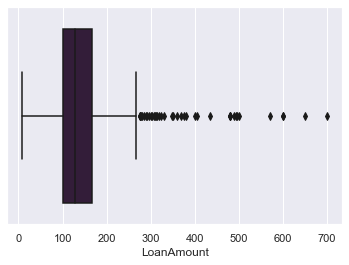

In [286]:
sns.boxplot(x="LoanAmount", data=df);

**Так как есть выбросы, заполним пустые значения медианой**

In [287]:
df['LoanAmount']=df['LoanAmount'].fillna(df['LoanAmount'].median())

In [288]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

**Таким образом, пустые значения отсутствуют**

<a id='task3'></a>

### EDA

**Loan Status - целевая переменная (принимает значения Y - если кредит одобрен и N если отклонен)**

In [289]:
df["Loan_Status"].unique()

array(['Y', 'N'], dtype=object)

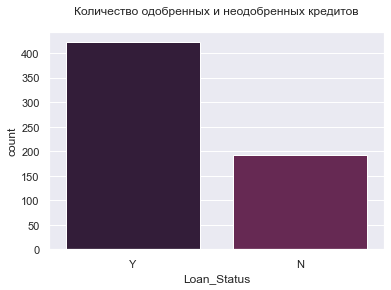

In [290]:
sns.countplot(df["Loan_Status"]).set_title("Количество одобренных и неодобренных кредитов\n");

In [291]:
pd.DataFrame(df["Loan_Status"].value_counts(normalize=True))

,Loan_Status
Y,0.687296
N,0.312704


**Одобрено около 69% кредитов**

Для расчета рейтинга успешности получения кредита добавим еще один признак - перекодируем Loan_Status в значения 1 и 0.

In [292]:
df['Loan_Status_bin'] = df['Loan_Status'].replace({'N':0, 'Y':1})

<a id='task3.1'></a>

**Gender (Male/Female)**

**Оценим влияние признака Gender на целевую переменную**

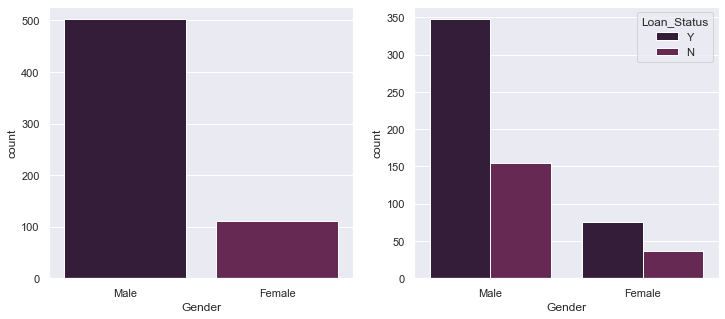

In [293]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(df["Gender"], ax=ax[0])
sns.countplot(df["Gender"], hue=df["Loan_Status"], ax=ax[1]);

In [294]:
pd.DataFrame(round(df['Gender'].value_counts(normalize=True)*100))

,Gender
Male,82.0
Female,18.0


In [295]:
df.groupby(['Gender'])[['Loan_Status_bin']].agg(['count','mean'])

Loan_Status_bin          
                 count      mean
Gender                          
Female             112  0.669643
Male               502  0.691235

In [296]:
pd.DataFrame(df.groupby(by="Gender")["Loan_Status"].value_counts())

Loan_Status
Gender Loan_Status             
Female Y                     75
       N                     37
Male   Y                    347
       N                    155

**Выводы:**  
1. 502 заявителя - 82% являются мужчинами и 112 - 18% женщинами
2. 75 женщин - 67%  и 347 мужчин - 69%  получили кредит
3. Разница составляет всего 2%, что говорит о том, что влияние данного фактора на целевую переменную незначительно.

<a id='task3.2'></a>

**Married (No/Yes)**

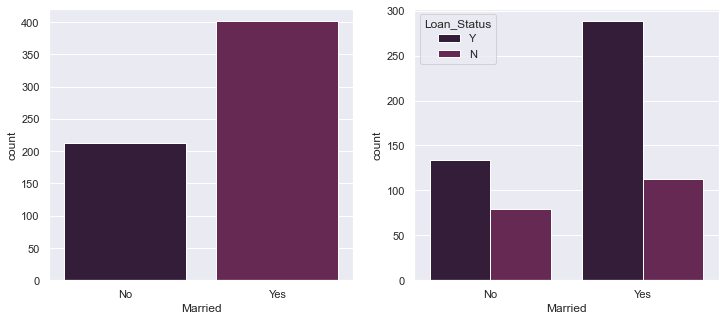

In [297]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(df['Married'], ax=ax[0])
sns.countplot(df['Married'], hue=df['Loan_Status'], ax=ax[1]);

In [298]:
pd.DataFrame(round(df['Married'].value_counts(normalize=True)*100))

,Married
Yes,65.0
No,35.0


In [299]:
df.groupby(['Married'])[['Loan_Status_bin']].agg(['count','mean'])

Loan_Status_bin          
                  count      mean
Married                          
No                  213  0.629108
Yes                 401  0.718204

In [300]:
pd.DataFrame(df.groupby(by="Married")["Loan_Status"].value_counts())

Loan_Status
Married Loan_Status             
No      Y                    134
        N                     79
Yes     Y                    288
        N                    113

**Выводы:**  
1. 401 заявитель - 65% в браке и 213 - 35% не в браке
2. 288 заявителей в браке - 72%  и 134 заявителя вне брака - 63%  получили кредит
3. Разница составляет уже 9%, что говорит о том, что влияние данного фактора на целевую переменную выше чем у предыдущего, т.е. шанс получить кредит на 9% выше если заявитель в браке.

<a id='task3.3'></a>

**Dependents (Иждивенцы - 0,1,2 или 3+)**

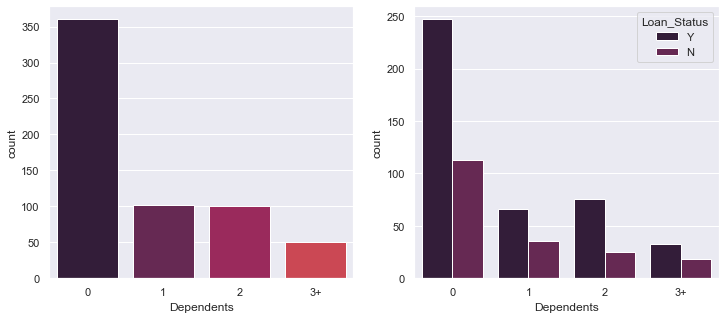

In [301]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(df['Dependents'], ax=ax[0])
sns.countplot(df['Dependents'], hue=df['Loan_Status'], ax=ax[1]);

In [302]:
pd.DataFrame(round(df['Dependents'].value_counts(normalize=True)*100))

,Dependents
0,59.0
1,17.0
2,16.0
3+,8.0


In [303]:
df.groupby(['Dependents'])[['Loan_Status_bin']].agg(['count','mean'])

Loan_Status_bin          
                     count      mean
Dependents                          
0                      360  0.686111
1                      102  0.647059
2                      101  0.752475
3+                      51  0.647059

In [304]:
pd.DataFrame(df.groupby(['Dependents'])['Loan_Status'].value_counts())

Loan_Status
Dependents Loan_Status             
0          Y                    247
           N                    113
1          Y                     66
           N                     36
2          Y                     76
           N                     25
3+         Y                     33
           N                     18

In [305]:
pd.DataFrame(df.groupby(['Dependents'])['Married'].value_counts(normalize=True))

Married
Dependents Married          
0          Yes      0.513889
           No       0.486111
1          Yes      0.774510
           No       0.225490
2          Yes      0.920792
           No       0.079208
3+         Yes      0.862745
           No       0.137255

**Выводы:**  
1. 360 заявителей - 59% не имеют иждивенцев, 102 - 17% - один, 101 - 16% - два и 51 - 8% три и более.
2. 247 чел. без иждивенцев - 68%, 66 чел. с 1 - 65%, 76 чел с двумя иждивенцами - 75% и 33 чел. с 3+ - 65% получили кредит.
3. Здесь можно заметить, что в группе людей с двумя иждивенцами % успешности получения кредитов составляет 75%, что в среднем на 10% выше, чем в других группах, но это влияние другого фактора, рассмотренного выше - статус брака. Так, в категории заявителей с двумя иждивенцами самый высокий % состоящих в браке - 92% по сравнению с другими группами (51%,77% и 86%).
4. Сам по себе данный фактор не существенно влияет на целевую переменную.

<a id='task3.4'></a>

**Education - (Graduate/Not Graduate)**

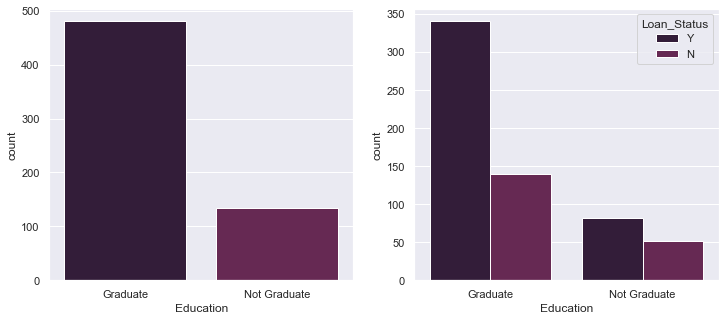

In [306]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(df['Education'], ax=ax[0])
sns.countplot(df['Education'], hue=df['Loan_Status'], ax=ax[1]);

In [307]:
pd.DataFrame(round(df['Education'].value_counts(normalize=True)*100))

,Education
Graduate,78.0
Not Graduate,22.0


In [308]:
df.groupby(['Education'])[['Loan_Status_bin']].agg(['count','mean'])

Loan_Status_bin          
                       count      mean
Education                             
Graduate                 480  0.708333
Not Graduate             134  0.611940

In [309]:
pd.DataFrame(df.groupby(['Education'])["Loan_Status"].value_counts())

Loan_Status
Education    Loan_Status             
Graduate     Y                    340
             N                    140
Not Graduate Y                     82
             N                     52

**Выводы:**  
1. 480 заявителей - 78% имеют высшее образование и 134 - 22% нет
2. 340 заявителей с образованием - 71%  и 82 заявителя без - 61%  получили кредит
3. Разница составляет 10%, что говорит о том, что имеется небольшое влияние данного фактора на целевую переменную, т.е. шанс получить кредит на 10% выше если заявитель имеет высшее образование.

<a id='task3.5'></a>

**Self Employed (No/Yes)**

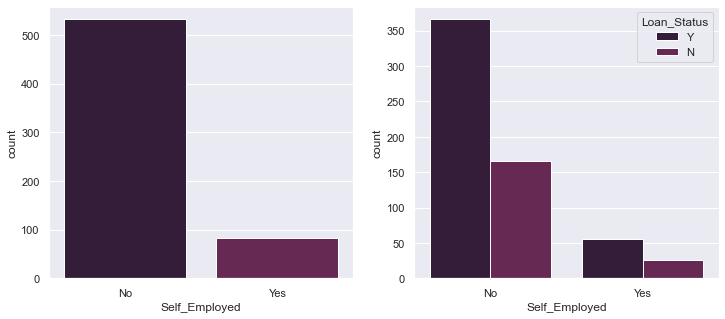

In [310]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(df['Self_Employed'], ax=ax[0])
sns.countplot(df['Self_Employed'], hue=df['Loan_Status'], ax=ax[1]);

In [311]:
pd.DataFrame(round(df['Self_Employed'].value_counts(normalize=True)*100))

,Self_Employed
No,87.0
Yes,13.0


In [312]:
df.groupby(['Self_Employed'])[['Loan_Status_bin']].agg(['count','mean'])

Loan_Status_bin          
                        count      mean
Self_Employed                          
No                        532  0.687970
Yes                        82  0.682927

In [313]:
pd.DataFrame(df.groupby(['Self_Employed'])["Loan_Status"].value_counts())

Loan_Status
Self_Employed Loan_Status             
No            Y                    366
              N                    166
Yes           Y                     56
              N                     26

**Выводы:**  
1. 532 заявителя - 87% не являются самозанятыми и только 82 чел. - 13% являются.
2. 366 чел., не являющихся самозанятыми - 69%  и 56 заявителей, являющихся - 68%  получили кредит.
3. Разница составляет менее 1%, что говорит о том, что этот фактор не влияет на целевую переменную.

<a id='task3.6'></a>

**Applicant Income**

In [314]:
df['ApplicantIncome'].describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

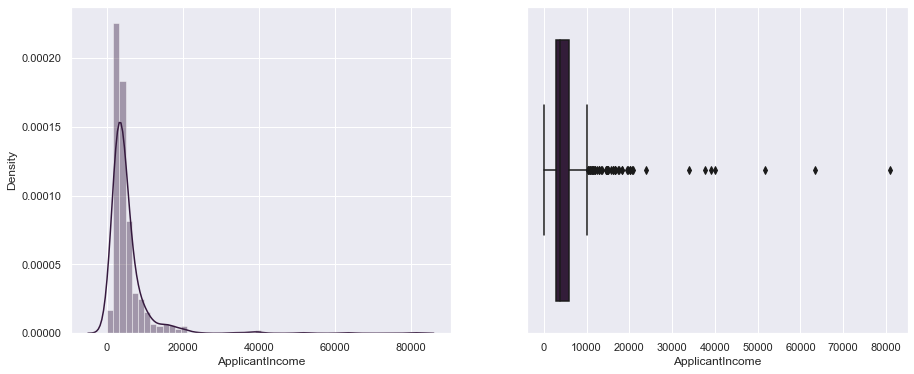

In [315]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.distplot(df['ApplicantIncome'], bins=50, ax=ax[0])
sns.boxplot(df['ApplicantIncome'], ax=ax[1]);

**Имеются проблемы с распределением, т.е при подготовке данных к моделированию нужно будет преобразовать данные с помощью логарифмирования**

**Изучим данные в сегменте, где ApplicantIncome > 30000**

In [316]:
df_ai = df[df['ApplicantIncome'] > 30000]
df_ai

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Loan_Status_bin
155,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y,1
171,Male,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y,1
183,Male,Yes,1,Graduate,No,33846,0.0,260.0,360.0,1.0,Semiurban,N,0
185,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y,1
333,Male,Yes,0,Graduate,No,63337,0.0,490.0,180.0,1.0,Urban,Y,1
409,Male,Yes,3+,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N,0
443,Male,No,1,Graduate,No,37719,0.0,152.0,360.0,1.0,Semiurban,Y,1


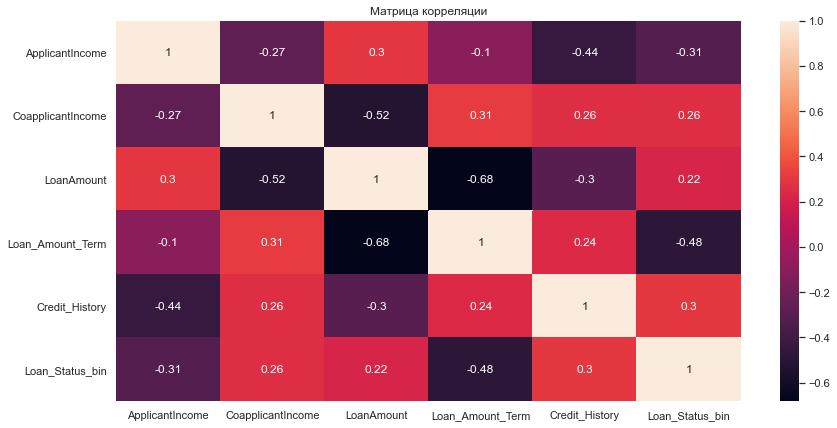

In [317]:
plt.figure(figsize=(14,7))
sns.heatmap(df_ai.corr(),annot=True)
plt.title('Матрица корреляции');

**В этом сегменте данных с целевой переменной больше всего коррелирует Loan_Amount_Term. Например заявитель с доходом 39999 просит кредит на 180 мес в размере 600 тыс. и получает его, тогда как заявитель с бОльшим доходом в 81000 просит кредит на меньшую сумму 360 тыс на 360 мес и не получает кредит, что довольно странно, к тому же срок кредита и сумма совпадают, что наводит на мысли об ошибке в данных, поэтому удалим это наблюдение.**

In [318]:
df_ai.drop(df_ai[df_ai['ApplicantIncome'] > 80000].index, axis=0, inplace=True)

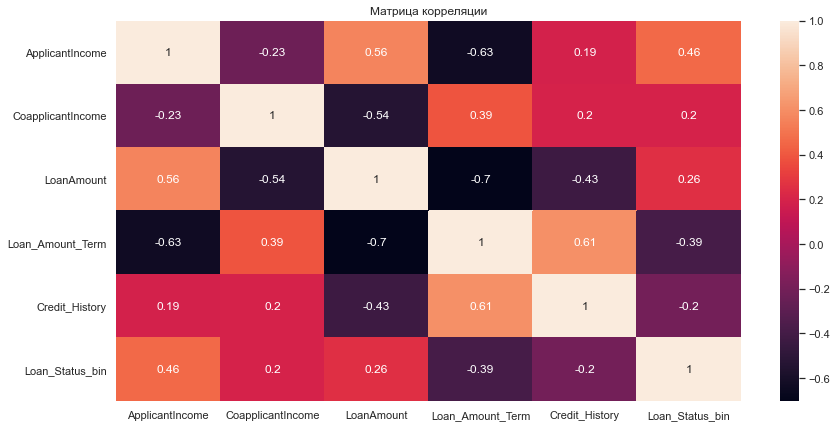

In [319]:
plt.figure(figsize=(14,7))
sns.heatmap(df_ai.corr(),annot=True)
plt.title('Матрица корреляции');

**Теперь матрица изменилась и наибольший коэффициент корреляции у ApplicantIncome, что вполне логично**

**Для изучения влияния ApplicantIncome на целевую переменную по всем данным сгруппируем значения**

In [320]:
df['ApplicantIncome_group'] = pd.cut(df['ApplicantIncome'],[0, 2900, 3900, 5800, 100000])

In [321]:
df.groupby('ApplicantIncome_group')['Loan_Status_bin'].agg(['count','mean'])

,count,mean
ApplicantIncome_group,,
"(0, 2900]",159,0.691824
"(2900, 3900]",162,0.697531
"(3900, 5800]",140,0.678571
"(5800, 100000]",153,0.679739


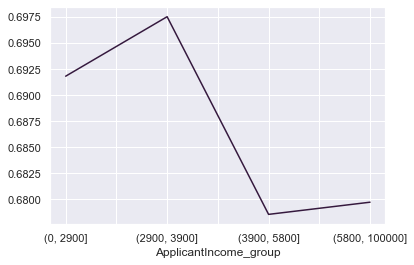

In [322]:
df.groupby('ApplicantIncome_group')['Loan_Status_bin'].mean().plot(grid=True);

**Выводы:**  
1. Непосредственно какой-то значимой зависимости целевой переменной от показателя ApplicantIncome не наблюдается.  
2. Необходимо анализировать влияние данного показателя на целевую переменную в совокупности с показателем Loan Amount.

**Co-applicant Income**

In [323]:
df['CoapplicantIncome'].describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

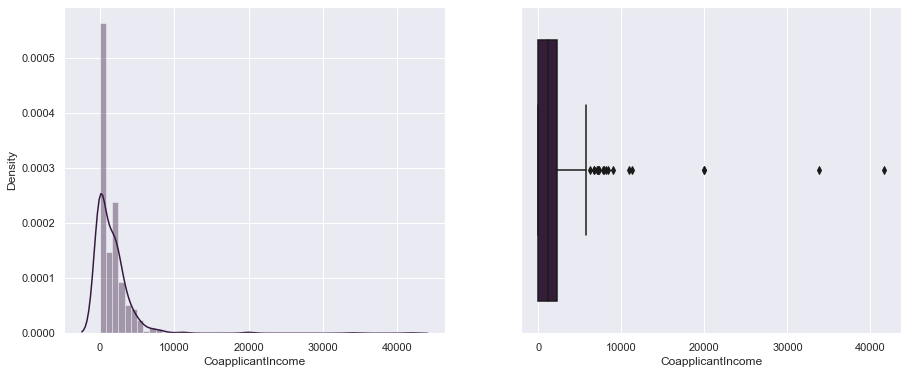

In [324]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.distplot(df['CoapplicantIncome'], bins=50, ax=ax[0])
sns.boxplot(df['CoapplicantIncome'], ax=ax[1]);

**Имеются проблемы с распределением, т.е при подготовке данных к моделированию нужно будет преобразовать данные с помощью логарифмирования**

**Изучим данные в сегменте, где CoapplicantIncome > 15000**

In [325]:
df_cai = df[df['CoapplicantIncome'] > 15000]
df_cai

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Loan_Status_bin,ApplicantIncome_group
402,Male,No,0,Graduate,No,2500,20000.0,103.0,360.0,1.0,Semiurban,Y,1,"(0, 2900]"
417,Male,Yes,2,Graduate,Yes,1600,20000.0,239.0,360.0,1.0,Urban,N,0,"(0, 2900]"
581,Male,No,0,Graduate,No,1836,33837.0,90.0,360.0,1.0,Urban,N,0,"(0, 2900]"
600,Female,No,3+,Graduate,No,416,41667.0,350.0,180.0,1.0,Urban,N,0,"(0, 2900]"


**Скорее всего здесь выбросы обусловлены ошибками в данных, т.к. при ApplicantIncome равном 2500 показатель CoapplicantIncome в 20000 выглядит ошибкой размерности, т.е. такие выбросы нужно удалить**

**Для изучения влияния CoapplicantIncome на целевую переменную по всем данным сгруппируем значения**

In [326]:
df['CoapplicantIncome_group'] = pd.cut(df['CoapplicantIncome'],[-0.0001, 1200.000, 2300.000, 42000.000])

In [327]:
df.groupby('CoapplicantIncome_group')['Loan_Status_bin'].agg(['count','mean'])

,count,mean
CoapplicantIncome_group,,
"(-0.0001, 1200.0]",307,0.677524
"(1200.0, 2300.0]",153,0.705882
"(2300.0, 42000.0]",154,0.688312


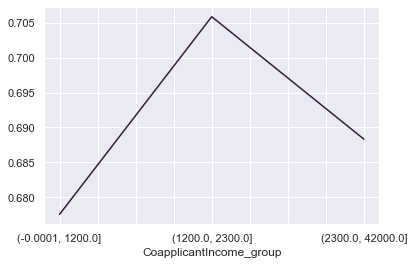

In [328]:
df.groupby('CoapplicantIncome_group')['Loan_Status_bin'].mean().plot(grid=True);

**Выводы:**  
1. Непосредственно какой-то значимой зависимости целевой переменной от показателя CoapplicantIncome не наблюдается.  
2. Необходимо анализировать влияние данного показателя на целевую переменную в совокупности с показателем Loan Amount.

<a id='task3.7'></a>

**Loan Amount**

In [329]:
df["LoanAmount"].describe()

count    614.000000
mean     145.752443
std       84.107233
min        9.000000
25%      100.250000
50%      128.000000
75%      164.750000
max      700.000000
Name: LoanAmount, dtype: float64

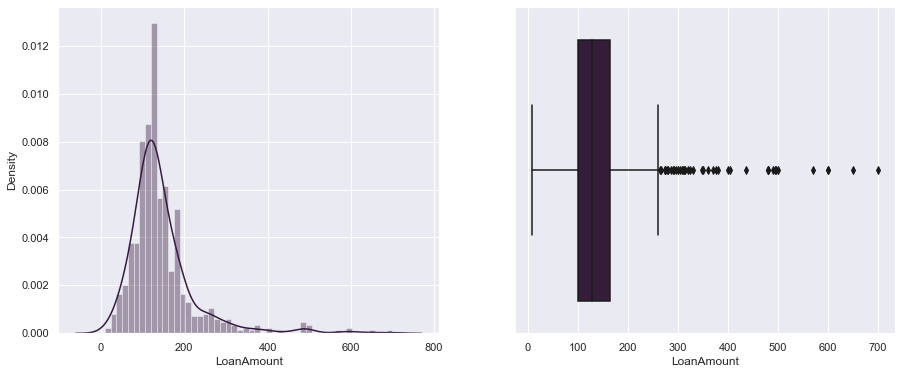

In [330]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.distplot(df['LoanAmount'], bins=50, ax=ax[0])
sns.boxplot(df['LoanAmount'], ax=ax[1]);

**Имеются проблемы с распределением, т.е при подготовке данных к моделированию нужно будет преобразовать данные с помощью логарифмирования**

**Изучим данные в сегменте, где LoanAmount > 400**

In [331]:
df_la = df[df['LoanAmount'] > 400]
df_la.sort_values('LoanAmount', ascending=False)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Loan_Status_bin,ApplicantIncome_group,CoapplicantIncome_group
171,Male,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y,1,"(5800, 100000]","(-0.0001, 1200.0]"
130,Male,No,0,Graduate,Yes,20166,0.0,650.0,480.0,1.0,Urban,Y,1,"(5800, 100000]","(-0.0001, 1200.0]"
155,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y,1,"(5800, 100000]","(-0.0001, 1200.0]"
561,Female,Yes,1,Graduate,Yes,19484,0.0,600.0,360.0,1.0,Semiurban,Y,1,"(5800, 100000]","(-0.0001, 1200.0]"
369,Male,Yes,0,Graduate,No,19730,5266.0,570.0,360.0,1.0,Rural,N,0,"(5800, 100000]","(2300.0, 42000.0]"
487,Male,Yes,1,Graduate,No,18333,0.0,500.0,360.0,1.0,Urban,N,0,"(5800, 100000]","(-0.0001, 1200.0]"
604,Female,Yes,1,Graduate,No,12000,0.0,496.0,360.0,1.0,Semiurban,Y,1,"(5800, 100000]","(-0.0001, 1200.0]"
177,Male,Yes,3+,Graduate,No,5516,11300.0,495.0,360.0,0.0,Semiurban,N,0,"(3900, 5800]","(2300.0, 42000.0]"
333,Male,Yes,0,Graduate,No,63337,0.0,490.0,180.0,1.0,Urban,Y,1,"(5800, 100000]","(-0.0001, 1200.0]"
308,Male,No,0,Graduate,No,20233,0.0,480.0,360.0,1.0,Rural,N,0,"(5800, 100000]","(-0.0001, 1200.0]"


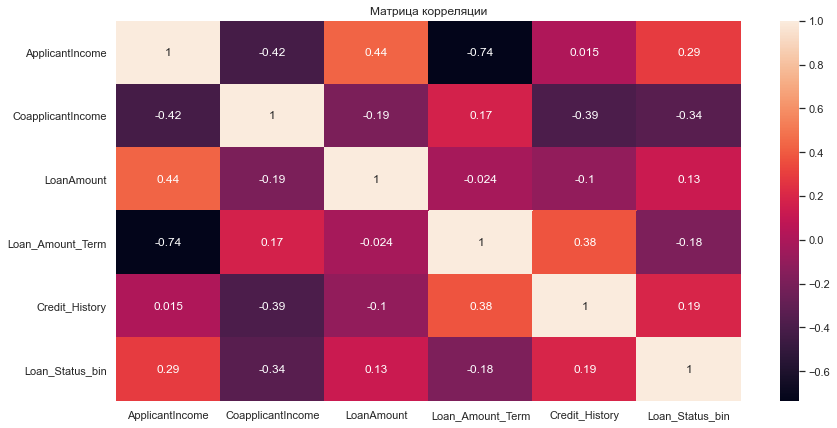

In [332]:
plt.figure(figsize=(14,7))
sns.heatmap(df_la.corr(),annot=True)
plt.title('Матрица корреляции');

**Данные и матрица корреляции выглядят не логично, т.к. чем больше доход со-заявителя, тем меньше шанс получить кредит - скорее всего это какие-то очень индивидуальные случаи либо ошибки в данных, т.е. такие выбросы нужно удалить**

**Для изучения влияния LoanAmount на целевую переменную сгруппируем значения**

In [333]:
df['LoanAmount_group'] = pd.cut(df['LoanAmount'],[9, 100, 130, 165, 700])

In [334]:
df.groupby('LoanAmount_group')['Loan_Status_bin'].agg(['count','mean'])

,count,mean
LoanAmount_group,,
"(9, 100]",153,0.699346
"(100, 130]",186,0.704301
"(130, 165]",123,0.699187
"(165, 700]",151,0.649007


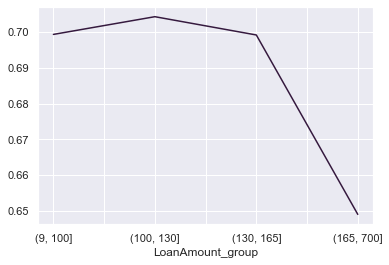

In [335]:
df.groupby('LoanAmount_group')['Loan_Status_bin'].mean().plot(grid=True);

In [336]:
df.groupby(['LoanAmount_group','CoapplicantIncome_group'])['Loan_Status_bin'].agg(['count','mean'])

count      mean
LoanAmount_group CoapplicantIncome_group                 
(9, 100]         (-0.0001, 1200.0]          104  0.653846
                 (1200.0, 2300.0]            34  0.823529
                 (2300.0, 42000.0]           15  0.733333
(100, 130]       (-0.0001, 1200.0]           87  0.701149
                 (1200.0, 2300.0]            62  0.693548
                 (2300.0, 42000.0]           37  0.729730
(130, 165]       (-0.0001, 1200.0]           47  0.638298
                 (1200.0, 2300.0]            34  0.705882
                 (2300.0, 42000.0]           42  0.761905
(165, 700]       (-0.0001, 1200.0]           68  0.720588
                 (1200.0, 2300.0]            23  0.565217
                 (2300.0, 42000.0]           60  0.600000

In [337]:
df.groupby(['LoanAmount_group','ApplicantIncome_group'])['Loan_Status_bin'].agg(['count','mean'])

count      mean
LoanAmount_group ApplicantIncome_group                 
(9, 100]         (0, 2900]                 65  0.723077
                 (2900, 3900]              56  0.678571
                 (3900, 5800]              24  0.625000
                 (5800, 100000]             8  0.875000
(100, 130]       (0, 2900]                 55  0.727273
                 (2900, 3900]              54  0.740741
                 (3900, 5800]              50  0.680000
                 (5800, 100000]            27  0.629630
(130, 165]       (0, 2900]                 23  0.695652
                 (2900, 3900]              37  0.702703
                 (3900, 5800]              38  0.710526
                 (5800, 100000]            25  0.680000
(165, 700]       (0, 2900]                 15  0.466667
                 (2900, 3900]              15  0.600000
                 (3900, 5800]              28  0.678571
                 (5800, 100000]            93  0.677419

**Выводы:**  
1. При запрашиваемых суммах выше 165 тыс.долл, кредит получили 65% заявителей, тогда как при суммах меньше 165 тыс. долл - около 70%, т.е шанс получить кредит на 5% выше если запрашиваемая сумма меньше 165 тыс.долл.
2. Влияние CoapplicantIncome на целевую переменную в совокупности с показателем Loan Amount можно оценить следующим образом -   при размере кредита до 100 тыс. лучший шанс 82% получить кредит имеют люди у которых со-заявители имеют доход от 1200 до 2300,   
при размере кредита до 130 тыс. лучший шанс равен 73% при доходе у со-заявителей от 2300 и   
при размере кредита до 165 тыс. лучший шанс равен 76% при доходе у со-заявителей от 2300.
3. Влияние ApplicantIncome на целевую переменную в совокупности с показателем Loan Amount можно оценить следующим образом -   
при размере кредита до 100 тыс. лучший шанс 88% получить кредит имеют люди с доходом от 5800,   
при размере кредита до 130 тыс. лучший шанс равен 74% при доходе от 2900 до 3900 ,   
при размере кредита до 165 тыс. лучший шанс равен 71% при доходе от 3900 до 5800 и   
при размере кредита до 700 тыс. лучший шанс равен 68% при доходе от 5800 до 100000. 

<a id='task3.8'></a>

**Loan Amount Term**

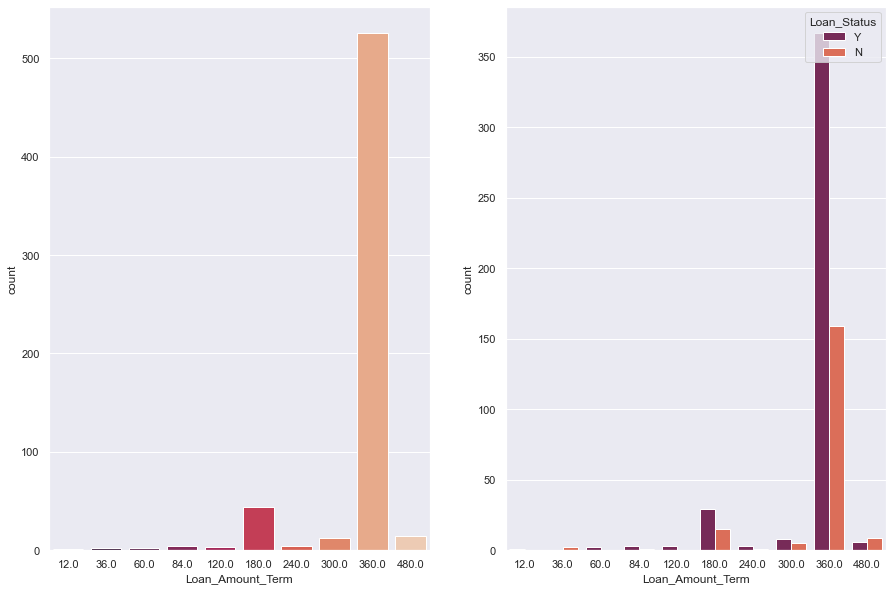

In [338]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
sns.countplot(df['Loan_Amount_Term'], palette="rocket", ax=ax[0])
sns.countplot(df['Loan_Amount_Term'], hue=df['Loan_Status'], palette="rocket", ax=ax[1]);

In [339]:
pd.DataFrame(df['Loan_Amount_Term'].value_counts())

,Loan_Amount_Term
360.0,526
180.0,44
480.0,15
300.0,13
84.0,4
240.0,4
120.0,3
36.0,2
60.0,2
12.0,1


**Для изучения влияния этого признака на целевую переменную сгруппируем значения Loan_Amount_Term, в три группы по принципу - до медианы, медианное значение и от медианы до максимума**

In [340]:
df['Loan_Amount_Term_group'] = pd.cut(df['Loan_Amount_Term'],[0, 350, 370, 480])

In [341]:
df.groupby('Loan_Amount_Term_group')['Loan_Status_bin'].agg(['count','mean'])

,count,mean
Loan_Amount_Term_group,,
"(0, 350]",73,0.671233
"(350, 370]",526,0.697719
"(370, 480]",15,0.400000


In [342]:
df.groupby(['Loan_Amount_Term_group'])[['Loan_Status_bin']].agg(['count','mean'])

Loan_Status_bin          
                                 count      mean
Loan_Amount_Term_group                          
(0, 350]                            73  0.671233
(350, 370]                         526  0.697719
(370, 480]                          15  0.400000

In [343]:
pd.DataFrame(df.groupby(['Loan_Amount_Term_group'])['Loan_Status'].value_counts())

Loan_Status
Loan_Amount_Term_group Loan_Status             
(0, 350]               Y                     49
                       N                     24
(350, 370]             Y                    367
                       N                    159
(370, 480]             N                      9
                       Y                      6

**Выводы:**  
1. При сроках до 360 месяцев включительно кредит получили 67% - 49 заявителей, при сроке в 360 мес.кредит получили 70% заявителей - 367 чел. и при сроке в 480 мес.кредит получили только 40% заявителей - 6 чел.
3. Таким образом, при запрашиваемом сроке до 360 мес. включительно шанс получить кредит выше на 30%.

<a id='task3.9'></a>

**Credit History (1-есть, 0-нет)**


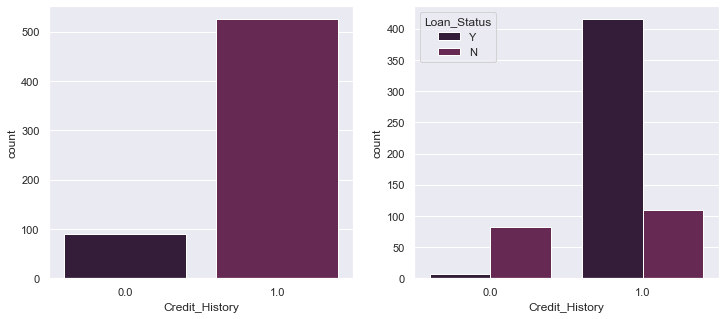

In [344]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(df['Credit_History'], ax=ax[0])
sns.countplot(df['Credit_History'], hue=df['Loan_Status'], ax=ax[1]);

In [345]:
pd.DataFrame(round(df['Credit_History'].value_counts(normalize=True)*100))

,Credit_History
1.0,86.0
0.0,14.0


In [346]:
df.groupby(['Credit_History'])[['Loan_Status_bin']].agg(['count','mean'])

Loan_Status_bin          
                         count      mean
Credit_History                          
0.0                         89  0.078652
1.0                        525  0.790476

In [347]:
pd.DataFrame(df.groupby(['Credit_History'])['Loan_Status'].value_counts())

Loan_Status
Credit_History Loan_Status             
0.0            N                     82
               Y                      7
1.0            Y                    415
               N                    110

**Выводы:**  
1. 525 заявителей - 86% имеют кредитную историю и 89 - 14% нет.
2. 415 заявителей с кредитной историей - 79%  и 7 заявитей без кредитной истории - 8%  получили кредит.
3. Разница составляет 71%, что говорит о том, что влияние данного фактора на целевую переменную огромно, т.е. шанс получить кредит на 71% выше если заявитель имеет подходящую кредитную историю.

<a id='task3.10'></a>

**Property Area**

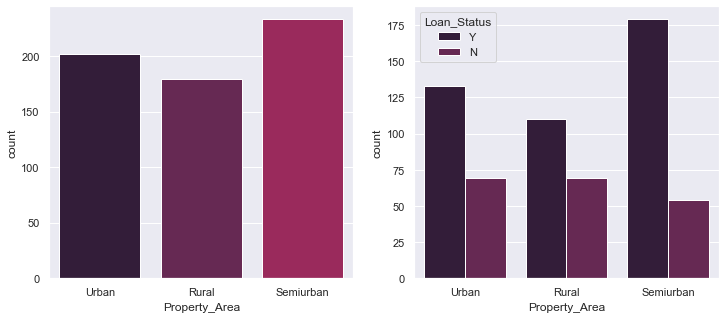

In [348]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(df['Property_Area'], ax=ax[0])
sns.countplot(df['Property_Area'], hue=df['Loan_Status'], ax=ax[1]);

In [349]:
pd.DataFrame(round(df['Property_Area'].value_counts(normalize=True)*100))

,Property_Area
Semiurban,38.0
Urban,33.0
Rural,29.0


In [350]:
df.groupby(['Property_Area'])[['Loan_Status_bin']].agg(['count','mean'])

Loan_Status_bin          
                        count      mean
Property_Area                          
Rural                     179  0.614525
Semiurban                 233  0.768240
Urban                     202  0.658416

In [351]:
pd.DataFrame(df.groupby('Property_Area')["Loan_Status"].value_counts())

Loan_Status
Property_Area Loan_Status             
Rural         Y                    110
              N                     69
Semiurban     Y                    179
              N                     54
Urban         Y                    133
              N                     69

**Выводы:**  
1. 233 заявителя имеют жилье в пригородных районах  - 38%, 202 в городских - 33% и 179 - 329% в сельских.
2. 179 заявителей с жильем в пригородных районах - 77%, 133 в городских - 66% и 110 в сельских - 61%  получили кредит.
3. Разница между категориями составляет до 16%, что говорит о том, что имеется влияние данного фактора на целевую переменную, т.е. шанс получить кредит на 16% выше если у заявителя жилье в пригородном районе.

<a id='task3.11'></a>

### Тесты

**Посмотрим на одной картинке, как связаны между собой различные признаки в наборе данных**

In [352]:
df_ready = df.drop(['Loan_Status','ApplicantIncome_group','CoapplicantIncome_group', 'LoanAmount_group','Loan_Amount_Term_group'], axis=1 )

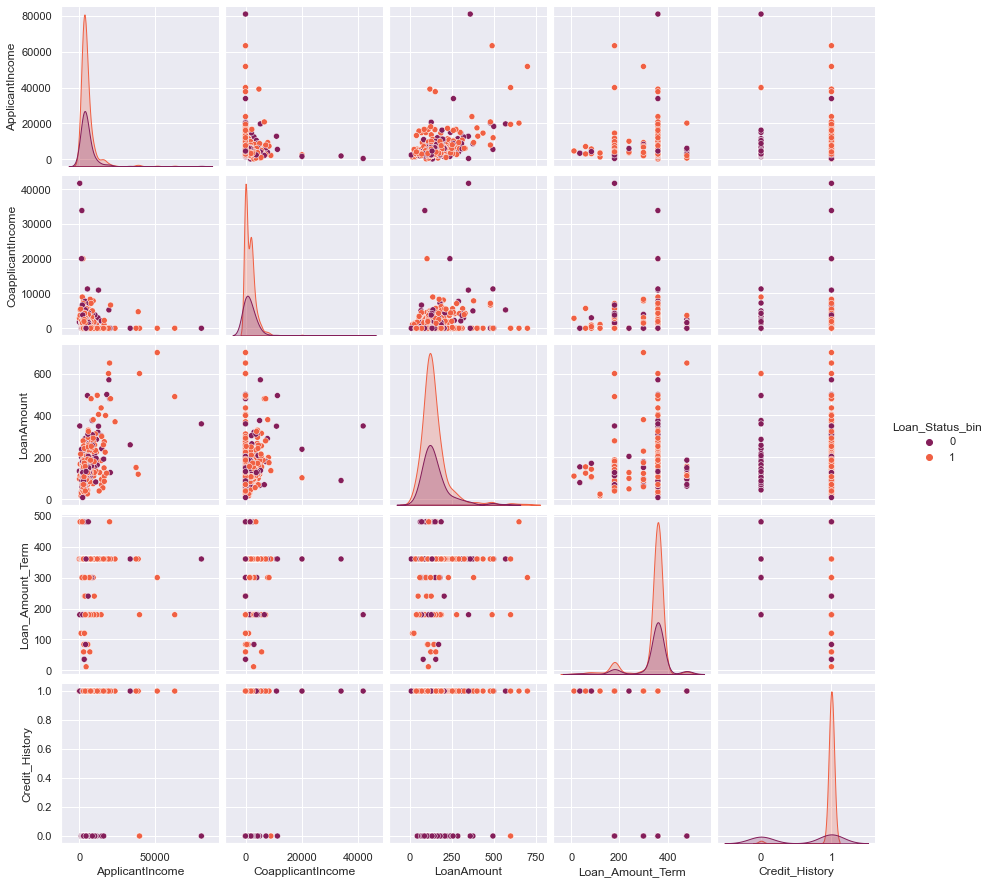

In [353]:
sns.pairplot(df_ready, hue = 'Loan_Status_bin', palette="rocket");

**Теперь посмотрим, с какими признаками коррелирует целевая переменная, для этого перекодируем категориальные признаки**

In [354]:
def object_col(df):
    return [x for x in df.columns if df[x].dtype == "object"]

def one_hot_encoding(df, columns):
    return pd.get_dummies(df, columns=columns)

cat_cols = object_col(df_ready)
df_encod = one_hot_encoding(df_ready, cat_cols)

In [355]:
df_ready.Gender.replace({'Male': 1, 'Female': 0}, inplace = True)
df_ready.Married.replace({'Yes': 1, 'No': 0}, inplace = True)
df_ready.Education.replace({'Graduate': 1, 'Not Graduate': 0}, inplace = True)
df_ready.Self_Employed.replace({'Yes': 1, 'No': 0}, inplace = True)
df_ready.Dependents.replace({'0':0,'1':1,'2':2,'3+':3}, inplace = True)
df_ready.Property_Area.replace({'Urban':2,'Rural':0,'Semiurban':1}, inplace = True)

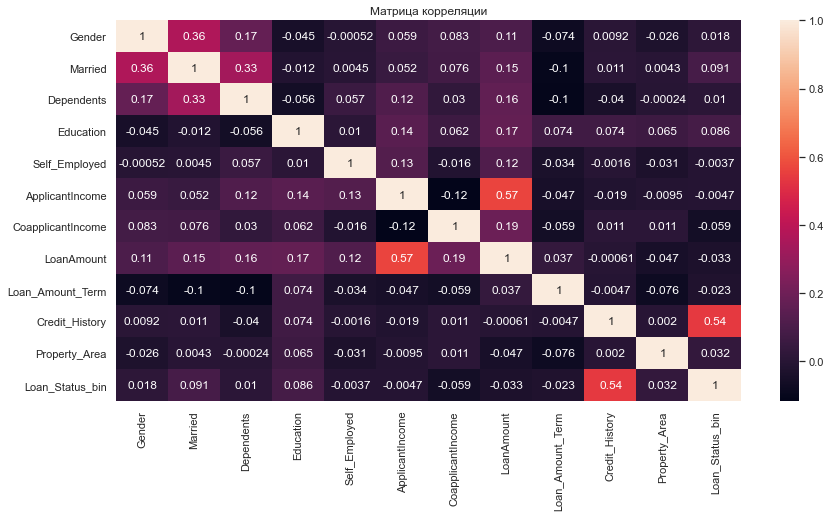

In [356]:
plt.figure(figsize=(14,7))
sns.heatmap(df_ready.corr(),annot=True)
plt.title('Матрица корреляции');

**Видно, что имеется корреляция между суммой кредита и величиной дохода заявителя**

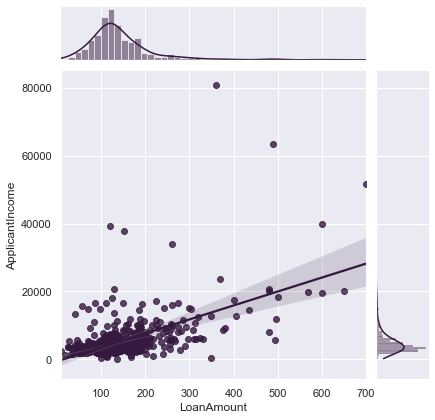

In [357]:
sns.jointplot(df_ready['LoanAmount'], df_ready['ApplicantIncome'], kind="reg");

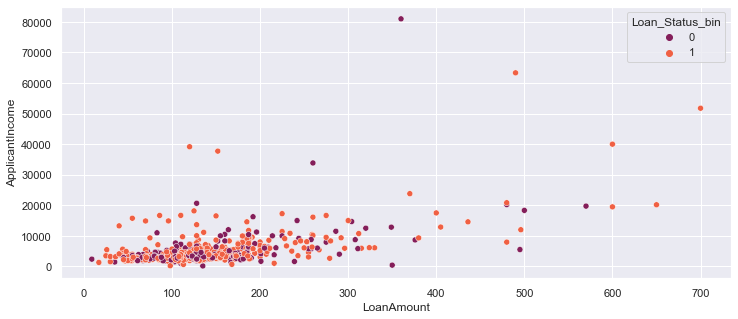

In [358]:
plt.figure(figsize=(12,5))
sns.scatterplot(df_ready['LoanAmount'], df_ready['ApplicantIncome'], hue=df_ready['Loan_Status_bin'], palette="rocket"); 

**Из вышеприведенных графиков следует:**
1. Заявителю, просящему большую сумму кредита, но имеющему низкий доход, будет трудно получить кредит, например, (250, 35000) и (350, 80000).
2. Заявитель, запрашивающий небольшую сумму кредита, но имеющий сравнительно высокий доход, легко получит кредит, например, (120, 40000) и (150, 39000)

**Изучим взаимосвязь показателей LoanAmount и CoapplicantIncome**

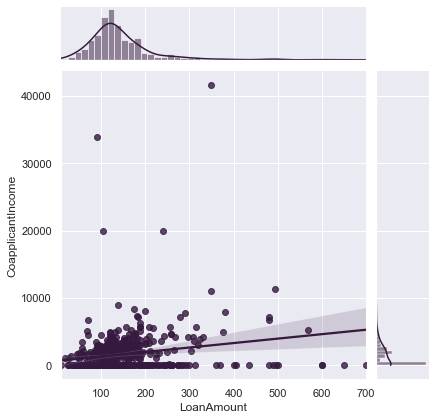

In [359]:
sns.jointplot(df_ready['LoanAmount'], df_ready['CoapplicantIncome'], kind="reg", palette="rocket");

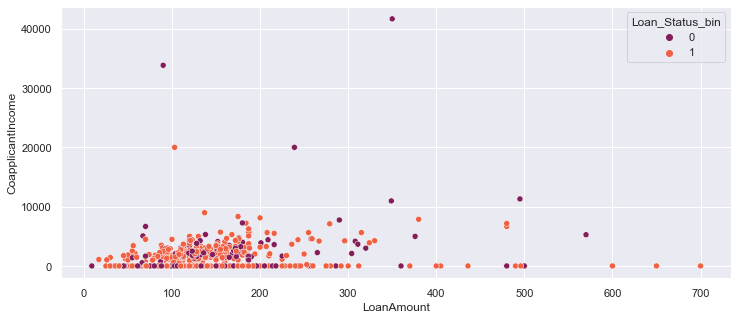

In [360]:
plt.figure(figsize=(12,5))
sns.scatterplot(df_ready['LoanAmount'], df_ready['CoapplicantIncome'], hue=df_ready['Loan_Status_bin'], palette="rocket"); 

**Вывод:**
1. Чем больше сумма дохода со-заявителя и меньше запрашиваемая сумма кредита, тем выше шанс получить кредит (50, 5000), (130,9000)
2. Если доход со-заявителя по сравнению с суммой кредита не велик, то кредит получить намного труднее (350, 11000), (490,11000)

<a id='task4'></a>

### Preprocessing

**Удаление выбросов**

In [361]:
df_no_outl = df_ready.copy()
df_no_outl.shape

(614, 12)

In [362]:
df_no_outl.drop(df_no_outl[df_no_outl['ApplicantIncome'] > 81000].index, axis=0, inplace=True)

In [363]:
df_no_outl.drop(df_no_outl[df_no_outl['CoapplicantIncome'] > 15000].index, axis=0, inplace=True)

In [364]:
df_no_outl.drop(df_no_outl[df_no_outl['LoanAmount'] > 400].index, axis=0, inplace=True)

In [365]:
df_no_outl.reset_index(drop=True, inplace=True)
df_no_outl.shape

(596, 12)

**Преобразование данных к нормальному распределению**

In [366]:
df_no_outl['ApplicantIncome'] = np.log(df_no_outl['ApplicantIncome'])
df_no_outl['CoapplicantIncome'] = [np.log(i) if i!=0 else 0 for i in df_no_outl['CoapplicantIncome']]
df_no_outl['LoanAmount'] = np.log(df_no_outl['LoanAmount'])

In [367]:
df_no_outl.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status_bin
0,1,0,0,1,0,8.674026,0.000000,4.852030,360.0,1.0,2,1
1,1,1,1,1,0,8.430109,7.318540,4.852030,360.0,1.0,0,0
2,1,1,0,1,1,8.006368,0.000000,4.189655,360.0,1.0,2,1
3,1,1,0,0,0,7.856707,7.765569,4.787492,360.0,1.0,2,1
4,1,0,0,1,0,8.699515,0.000000,4.948760,360.0,1.0,2,1


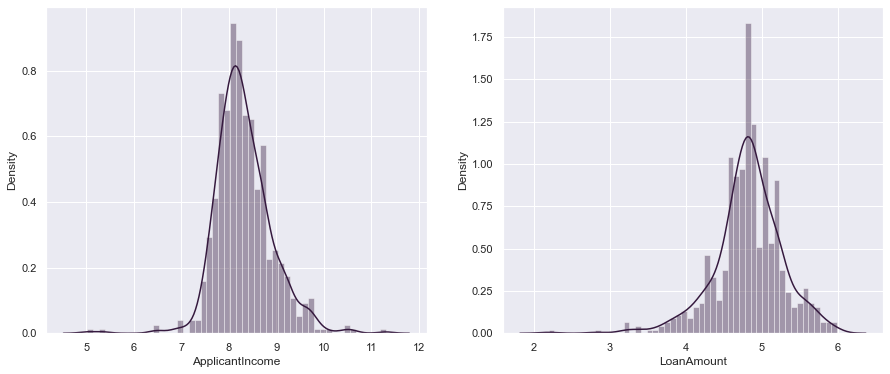

In [368]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.distplot(df_no_outl['ApplicantIncome'], bins=50, ax=ax[0])
sns.distplot(df_no_outl['LoanAmount'], bins=50, ax=ax[1]);

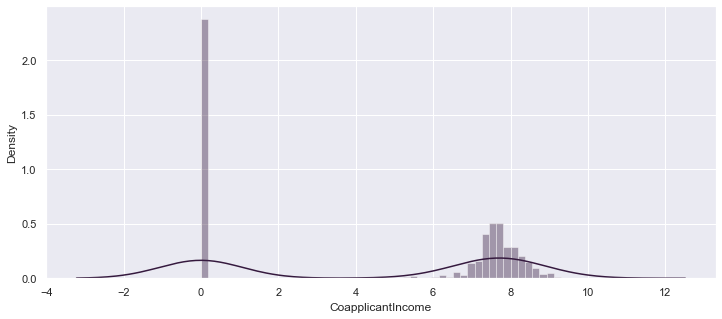

In [369]:
plt.figure(figsize=(12,5))
sns.distplot(df_no_outl['CoapplicantIncome'], bins=50);

<a id='task5'></a>

### Model

In [370]:
X = df_no_outl.drop(columns=['Loan_Status_bin'], axis=1)
y = df_no_outl['Loan_Status_bin']

**разделим выборку на тренировочную и тестовую**

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Стандартизация/Нормализация данных**

Стандартизация данных выполняется с помощью Standard-Scaler, который масштабирует данные так, чтобы среднее значение наблюдаемых данных было равно 0, а стандартное отклонение - 1.

In [372]:
StSc = StandardScaler()
X_train  = StSc.fit_transform(X_train)
X_test  = StSc.fit_transform(X_test)

**Построение модели логистической регрессии и дерева решений и расчет точности - отношение верный прогнозов к общему количеству позиций**

In [373]:
Model_1 = LogisticRegression()
Model_1.fit(X_train,y_train)
y_pred = Model_1.predict(X_test)
print(classification_report(y_pred,y_test))
print('Logistic Regression:',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.45      0.95      0.61        20
           1       0.99      0.82      0.90       129

    accuracy                           0.84       149
   macro avg       0.72      0.89      0.76       149
weighted avg       0.92      0.84      0.86       149

Logistic Regression: 0.8389261744966443


In [374]:
Model_2 = DecisionTreeClassifier()
Model_2.fit(X_train,y_train)
y_pred = Model_2.predict(X_test)
print(classification_report(y_pred,y_test))
print('DecisionTreeClassifier:',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57        49
           1       0.79      0.84      0.81       100

    accuracy                           0.74       149
   macro avg       0.70      0.69      0.69       149
weighted avg       0.73      0.74      0.73       149

DecisionTreeClassifier: 0.738255033557047


<a id='task6'></a>

In [375]:
df_fi_Model_1 = pd.DataFrame({'feature_names':list(X.columns),'feature_importance':np.abs(Model_1.coef_[0])})\
                            .sort_values(by=['feature_importance'], ascending=False)

In [376]:
df_fi_Model_2 = pd.DataFrame({'feature_names':list(X.columns),'feature_importance':Model_2.feature_importances_})\
                            .sort_values(by=['feature_importance'], ascending=False)

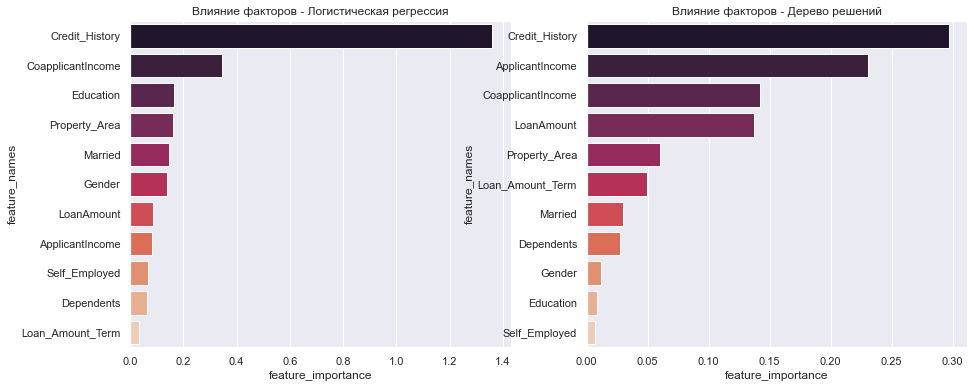

In [377]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.barplot(x=df_fi_Model_1['feature_importance'], y=df_fi_Model_1['feature_names'], ax=ax[0], palette="rocket").set_title('Влияние факторов - Логистическая регрессия')
sns.barplot(x=df_fi_Model_2['feature_importance'], y=df_fi_Model_2['feature_names'], ax=ax[1], palette="rocket").set_title('Влияние факторов - Дерево решений');

### Выводы

**После проведенного анализа можно выделить следующие тенденции и факторы, влияющие на целевую переменную.**
1. Социально-демографические факторы -  
    шанс получить кредит:
- на 16% выше если у заявителя жилье в пригородном районе;
- на 10% выше если заявитель имеет высшее образование;
- на 9% выше если заявитель в браке.

2. Факторы, связанные с доходом и условиями кредитования -  
    шанс получить кредит: 
- на 71% выше если заявитель имеет подходящую кредитную историю;
- на 30% при запрашиваемом сроке до 360 мес. включительно;
- на 5% выше если запрашиваемая сумма меньше 165 тыс.долл;

- Заявитель, запрашивающий небольшую сумму кредита, но имеющий сравнительно высокий доход, легко получит кредит
- при размере кредита до 100 тыс. лучший шанс 88% получить кредит имеют люди с доходом от 5800,
- при размере кредита до 130 тыс. лучший шанс равен 74% при доходе от 2900 до 3900,
- при размере кредита до 165 тыс. лучший шанс равен 71% при доходе от 3900 до 5800 и
- при размере кредита до 700 тыс. лучший шанс равен 68% при доходе от 5800 до 100000.

- Если доход со-заявителя по сравнению с суммой кредита не велик, то кредит получить намного труднее
- при размере кредита до 100 тыс. лучший шанс 82% получить кредит имеют люди у которых со-заявители имеют доход от 1200 до 2300,
- при размере кредита до 130 тыс. лучший шанс равен 73% при доходе у со-заявителей от 2300 и
- при размере кредита до 165 тыс. лучший шанс равен 76% при доходе у со-заявителей от 2300.

3. На основе двух моделей для решения задачи классификации определились топ-3 самых факторов, имеющих наибольшее влияние на целевую переменную:
- Наличие кредитной истории,
- Доход со-заемщиков,
- Размер кредита.
  Все эти факторы связаны с доходом и условиями кредитования.  

4. Но топ-5 факторов, влияющих на целевую переменную совпали по выводам ручного анализа и модели Логистической регрессии:
- Наличие кредитной истории,
- Доход со-заемщика;
- Жилье в пригородном районе;
- Высшее образование;
- Размер кредита.  
  Два из этих факторов являются социально-демографическими, таким образом, можно сказать, что влияние социально-демографических факторов нельзя полностью отвергать несмотря на результаты расчетов по моделям.






